In [2]:
from skimage import data, io, segmentation, color
from skimage.future import graph
import numpy as np
from scipy import ndimage
from scipy import signal
from scipy import misc
from scipy.signal import convolve2d
import pandas as pd
IA = io.imread('clock1.jpg', gray=True)
IB = io.imread('clock2.jpg', gray=True)

In [3]:
def Focus_Measure(I):
    xj=np.pad(I,((1,1),(1,1)),'symmetric')
    EOL = convolve2d(xj, np.array([[1,4,1],[4,-20,4],[1, 4, 1]])/6, mode='valid')
    E_2 = EOL*EOL
    FM = convolve2d(E_2, np.ones((8,8)), mode='valid')
    Mp = FM[0::8, 0::8]
    return Mp

In [4]:
def Majority_Filter(D,l):
    D = D - 0.5
    w = np.ones((l,l));
    D = convolve2d(D,w,mode='same')
    Db = (D > 0).astype(np.float32)
    return Db

In [5]:
def  boxfilter(imSrc, r):
    (hei, wid) = imSrc.shape
    imDst = np.zeros((hei, wid));
    #cumulative sum over Y axis
    imCum = np.cumsum(imSrc, axis=0)
    #difference over Y axis
    imDst[0:r+1, :] = imCum[r:2*r+1, :];
    imDst[r+1:hei-r, :] = imCum[2*r+1:hei, :] - imCum[0:hei-2*r-1, :];
    imDst[hei-r:hei, :] = np.matlib.repmat(imCum[hei-1, :], r, 1) - imCum[hei-2*r-1:hei-r-1, :]

    #cumulative sum over X axis
    imCum = np.cumsum(imDst, axis=1)
    #difference over X axis
    imDst[:, 0:r+1] = imCum[:, r:2*r+1];
    imDst[:, r+1:wid-r] = imCum[:, 2*r+1:wid] - imCum[:, 0:wid-2*r-1]
    imDst[:, wid-r:wid] = np.matlib.repmat(np.array([imCum[:, wid-1]]).T, 1, r) - imCum[:, (wid-(2*r))-1:wid-r-1]
    return imDst

In [6]:
def guidedfilter(I, p, r, eps):
    (hei, wid) = I.shape
    N = boxfilter(np.ones((hei, wid)), r)
    mean_I =  boxfilter(I, r)/N
    mean_p =  boxfilter(p, r)/N
    mean_Ip =  boxfilter(I*p, r)/N
    cov_Ip = mean_Ip - mean_I*mean_p
    mean_II = boxfilter(I*I, r)/N
    var_I = mean_II - mean_I*mean_I
    a = cov_Ip/(var_I + eps)
    b = mean_p-a*mean_I
    mean_a = boxfilter(a, r)/N
    mean_b = boxfilter(b, r)/N
    q = mean_a*I + mean_b
    return q

In [7]:
def Jihmsp_Kun_Zhan(IA,IB):
    MpA = Focus_Measure(IA)
    MpB = Focus_Measure(IB)
    D = (MpA > MpB).astype(np.float32)
    Db = Majority_Filter(D,6)
    Db = Majority_Filter(Db,7)
    w = np.ones((8,8))
    Dp = np.kron(Db, w)
    r = 60
    eps = 0.03
    D2 = guidedfilter(IA, Dp, r, eps)
    Fs = D2*IA+(1-D2)*IB
    F = np.uint8(Fs)
    return F

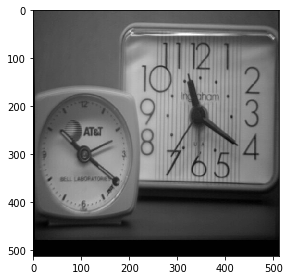

In [8]:
#Multi-focus
C =Jihmsp_Kun_Zhan(IA,IB)
io.imshow(C)
io.show()

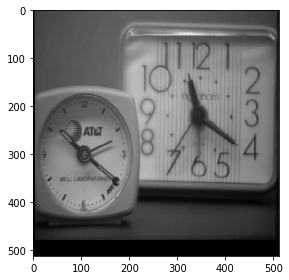

In [9]:
#Bokeh
#Bluring back
#f is the same meaning as aparture in camera with range 0 - 1
f=0.5
X = np.uint8((1-f)*(IB.astype(np.float32))+f*(C.astype(np.float32)))
io.imshow(X)
io.show()

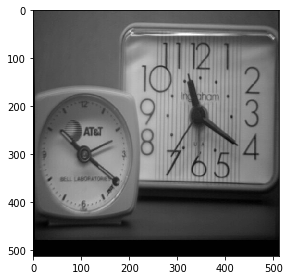

In [10]:
#Bokeh
#Bluring front
#f is the same meaning as aparture in camera with range 0 - 1
f=1
X = np.uint8((1-f)*(IA.astype(np.float32))+f*(C.astype(np.float32)))
io.imshow(X)
io.show()
print()